# Emotion Detection from scratch

**Author:** Yash Kumar <br>
**Linkedin:** https://www.linkedin.com/in/yash-kumar-01573a153/ <br>
**Date created:** 07-August-2024<br>
**Description:** Training an image classifier from scratch on the Kaggle FER-2013 Dataset.

# Data Set-

Kaggle - https://www.kaggle.com/datasets/msambare/fer2013

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories.

(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)


# Setting up Kaggle Directory

In [2]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 86% 52.0M/60.3M [00:00<00:00, 110MB/s] 
100% 60.3M/60.3M [00:00<00:00, 100MB/s]


In [4]:
!unzip /content/fer2013.zip -d /content/
print()

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  
  inflating: /content/train/sad/Training_65508578.jpg  

# Installing Packages

In [5]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,auc
import cv2
import tensorflow as tf
from PIL import Image
import imghdr

from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras import layers,models,regularizers,optimizers
from tensorflow.keras.layers import Conv2D,Dense,Embedding,MaxPooling2D,BatchNormalization,Dropout,Activation,GlobalAveragePooling2D,Flatten
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam,Adamax
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,TensorBoard,CSVLogger

from keras.utils import plot_model


from tensorflow.keras.applications import VGG16, ResNet50V2

# Setting up Directory to save model data.

In [6]:
project_name='FER_2013_emotion_detection'
model_name=['Custom_CNN_from_scratch',
            'Custom_CNN_with_augmentation',
            'Vgg16_transfer_learning',
            'Resnet50_transfer_learning']
base_dir='/content/'
project_dir=os.path.join(base_dir,project_name)
os.makedirs(project_dir,exist_ok=True)
for model in model_name:
  model_dir=os.path.join(project_dir,model)
  os.makedirs(model_dir,exist_ok=True)

# Data Cleaning

In [7]:
img_exist=['jpeg','jpg','png']
data_dir='/cont/train'
for root,dir,files in os.walk(data_dir):
  for file in files:
    file_path=os.path.join(root,file)
    try:
      file_type=os.imghdr.what(file_path)
      if file_type not in img_exist:
        os.remove(file_path)
      else:
        img=cv2.imread(file_path)
    except:
      os.remove(file_path)

# Data Analysis

In [8]:
def count_dir_item(dir,name):
  count_item={}
  for item in os.listdir(dir):
    item_path=os.path.join(dir,item)
    if os.path.isdir(item_path):
      count_item[item]=len(os.listdir(item_path))
  df=pd.DataFrame(count_item,index=[name])
  return df
train_dir='/content/train'
test_dir='/content/test'
train_count=count_dir_item(train_dir,'train')
test_count=count_dir_item(test_dir,'test')
print(train_count)
print(test_count)

       angry  happy  disgust   sad  fear  neutral  surprise
train   3995   7215      436  4830  4097     4965      3171
      angry  happy  disgust   sad  fear  neutral  surprise
test    958   1774      111  1247  1024     1233       831


## Visualization

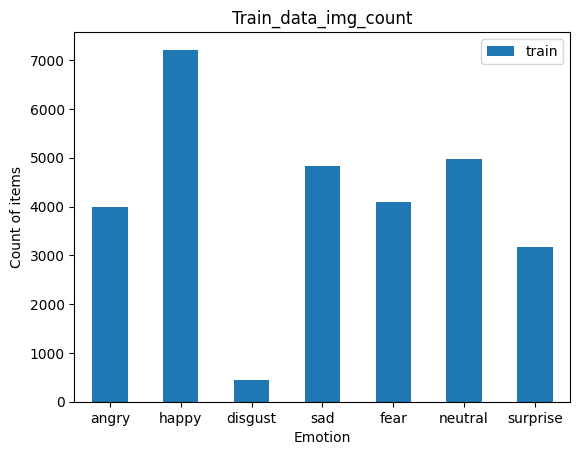

In [9]:
train_count.transpose().plot(kind='bar')
plt.title('Train_data_img_count')
plt.xticks(rotation=0)
plt.xlabel('Emotion')
plt.ylabel('Count of items')
plt.show()

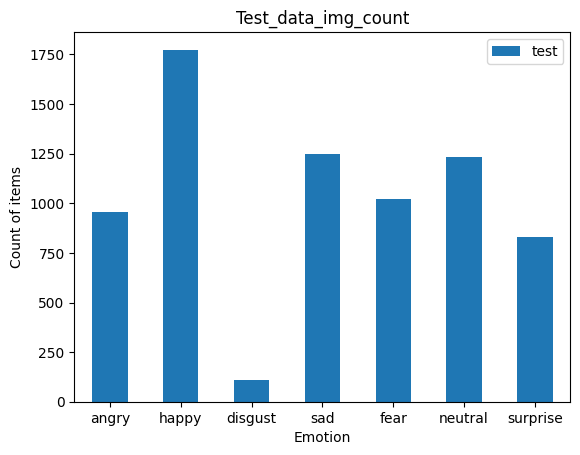

In [10]:
test_count.transpose().plot(kind='bar')
plt.title('Test_data_img_count')
plt.xticks(rotation=0)
plt.xlabel('Emotion')
plt.ylabel('Count of items')
plt.show()

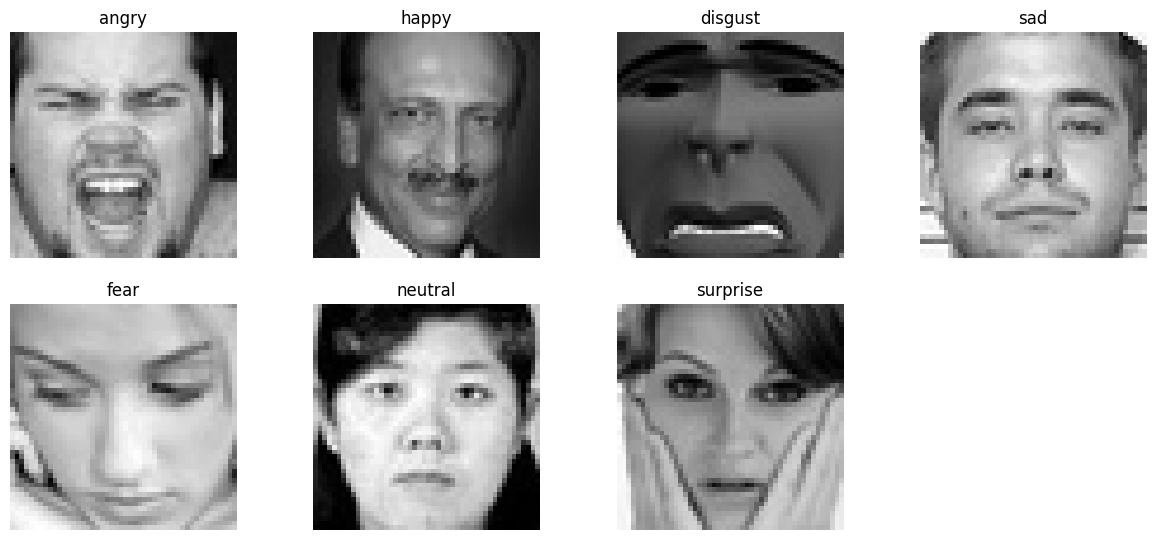

In [11]:
emotions=os.listdir(train_dir)
plt.figure(figsize=(15,10))
emotions
for i,emotion in enumerate(emotions,1):
  folder_path=os.path.join(train_dir,emotion)
  img_path=os.path.join(folder_path,os.listdir(folder_path)[random.randint(0,400)])
  img=plt.imread(img_path)
  plt.subplot(3, 4, i)
  plt.imshow(img, cmap='gray')
  plt.title(emotion)
  plt.axis('off')

In [12]:
def plot_img_dir(dir,class_name,num=9):
  if len(os.listdir(dir))<num:
    return 'You asked too much images from dir that much images is not there'
  else:
    sel_img=random.sample(os.listdir(dir),num)
    fig,axes=plt.subplots(3,3,figsize=(5,5))
    axes=axes.ravel()
    for i,img in enumerate(sel_img):
      img_path=os.path.join(dir,img)
      img=load_img(img_path)
      axes[i].imshow(img)
      axes[i].set_title(f'Image: {class_name}')
      axes[i].axis('off')
  plt.tight_layout()
  plt.show()


In [13]:
def print_img(name):
  class_path='/content/train/'+name
  return plot_img_dir(class_path,name,9)

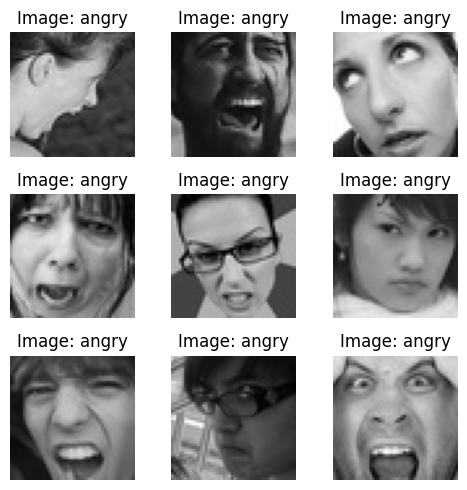

None


In [14]:
print(print_img('angry'))

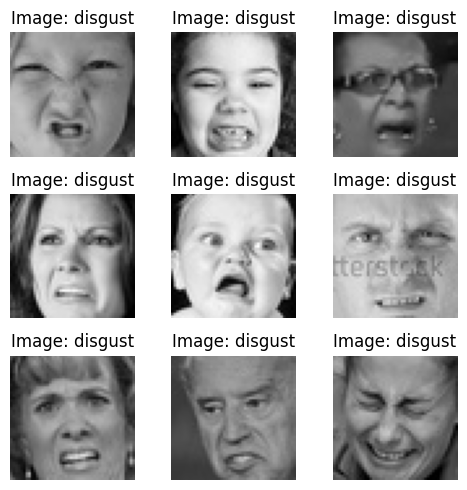

In [15]:
print_img('disgust')

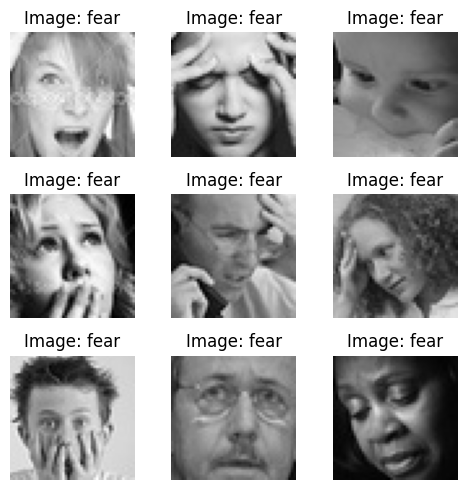

In [16]:
print_img('fear')

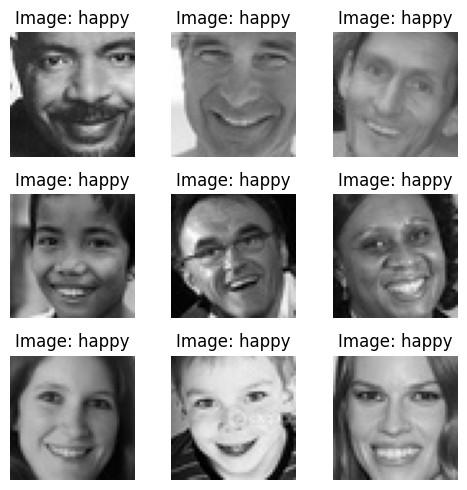

In [17]:
print_img('happy')

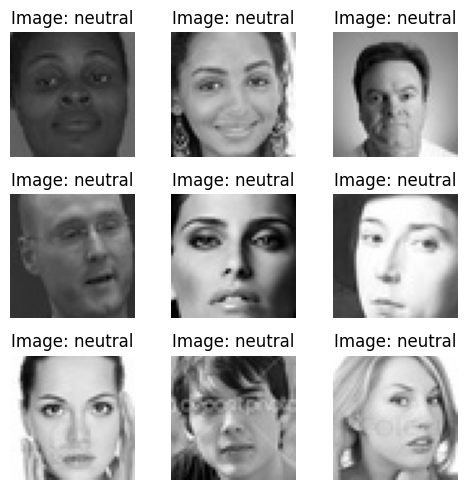

In [18]:
print_img('neutral')

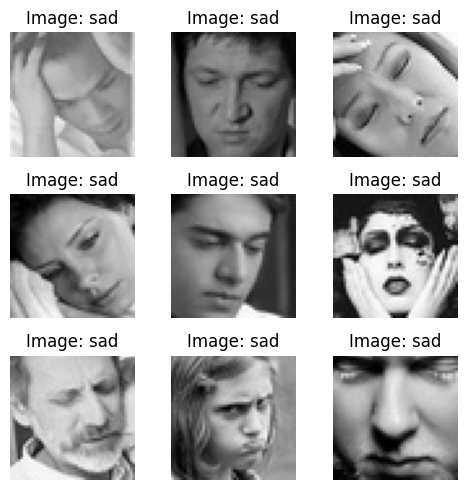

In [19]:
print_img('sad')

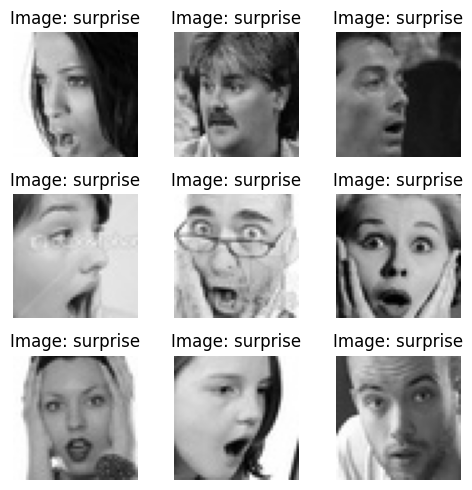

In [20]:
print_img('surprise')

# Checking shapes and channels.

In [21]:
img_path='/content/train/angry/Training_10118481.jpg'
import cv2
img=cv2.imread(img_path)
if img is not None:
  print(img.shape)
else:
  print('Issue in path')

(48, 48, 3)


In [22]:
img_path='/content/train/angry/Training_10118481.jpg'
import cv2
img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
if img is not None:
  print(img.shape)
else:
  print('Issue in path')

(48, 48)


# Model 1 : Custom CNN from Scratch

## Initializing the ImageGenerators

In [ ]:
train_dir='/content/train'
test_dir='/content/test'

In [ ]:
img_width,img_height=48,48
batch=64
epoch=10
num_classes=7

In [ ]:
data_generator=ImageDataGenerator(rescale=1./255,validation_split=0.2)
train_generator=data_generator.flow_from_directory(train_dir,
                               target_size=(img_width,img_height),
                               batch_size=batch,
                               class_mode='categorical',
                               color_mode='grayscale',
                               subset='training')
validation_generator=data_generator.flow_from_directory(train_dir,
                               target_size=(img_width,img_height),
                               batch_size=batch,
                               class_mode='categorical',
                               color_mode='grayscale',
                               subset='validation')
test_generator=data_generator.flow_from_directory(test_dir,
                               target_size=(img_width,img_height),
                               batch_size=batch,
                               class_mode='categorical',
                               color_mode='grayscale')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
train_class_labels=train_generator.class_indices
print('Training class labels:',train_class_labels)

validation_class_labels=validation_generator.class_indices
print('Validation class labels:',validation_class_labels)

test_class_labels=test_generator.class_indices
print('Testing class labels:',test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Testing class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),kernel_initializer='glorot_uniform',padding='same',input_shape=(img_width,img_height,1)))
model.add(Activation('relu'))
model.add(Conv2D(64,kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256,kernel_size=(3,3),kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 11, 11, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 512)           │              

 Total params: 17,046,535 (65.03 MB)

 Trainable params: 17,044,871 (65.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

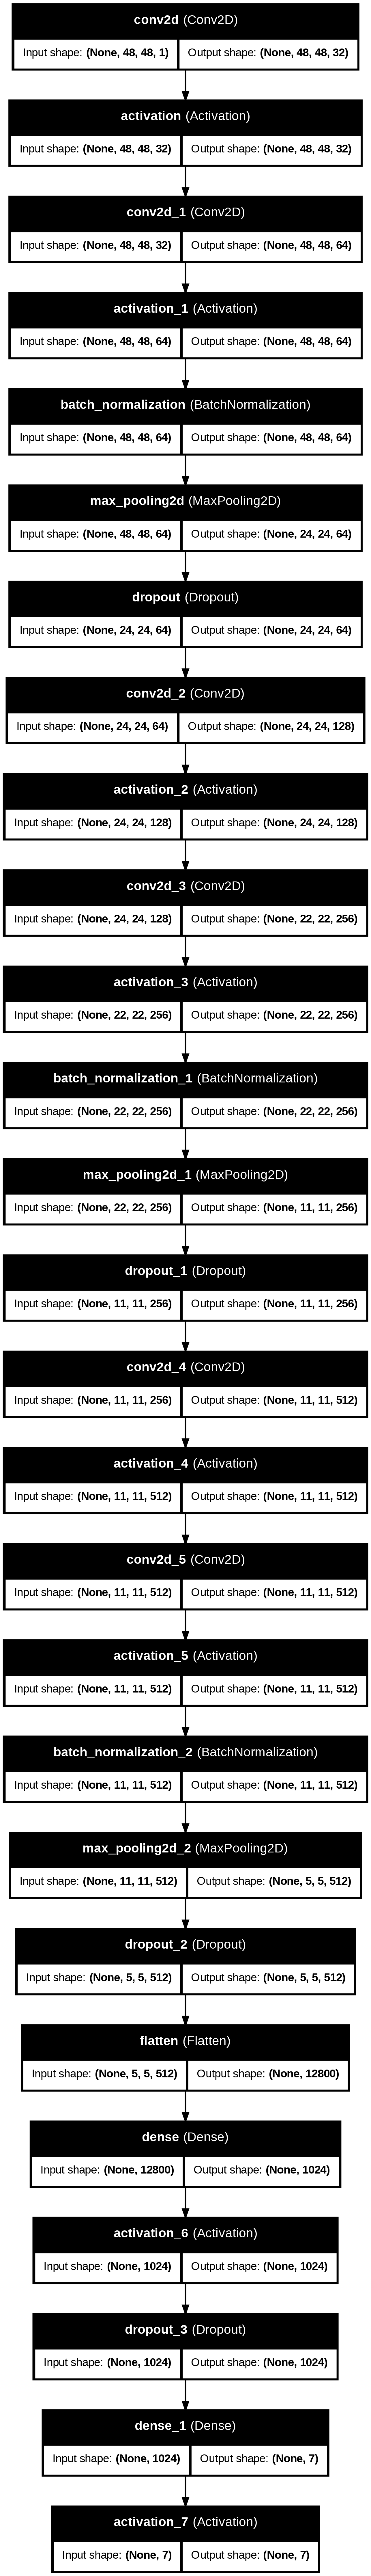

In [ ]:
plot_model(model,to_file='/content/FER_2013_emotion_detection/Custom_CNN_from_scratch/Architecture.png',show_shapes=True,
           show_layer_names=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

# Understanding Callbacks

In [ ]:
cnn_path='/content/FER_2013_emotion_detection/Custom_CNN_from_scratch'
name='Custom_CNN_Models.keras'
chk_path=os.path.join(cnn_path,name)
chk_path

'/content/FER_2013_emotion_detection/Custom_CNN_from_scratch/Custom_CNN_Models.keras'

In [ ]:
checkpoint=ModelCheckpoint(filepath=chk_path,
                           save_best_only=True,
                           verbose=1,
                           mode='min',
                           monitor='val_loss')

In [ ]:
earlystop=EarlyStopping(monitor='val_loss',
                            min_delta=0.001,
                            patience=3,
                            verbose=1,
                            restore_best_weights=True)

In [ ]:
reduce_lr=ReduceLROnPlateau(monitor='val_loss',
                            factor=0.2,
                            patience=6,
                            verbose=1,
                            min_delta=0.0001)

In [ ]:
csvlogger=CSVLogger(os.path.join(cnn_path,'training.log'))

In [ ]:
callback=[checkpoint,earlystop,reduce_lr,csvlogger]

# Calculating Steps for epoch

In [ ]:
train_steps_per_epoch=train_generator.samples//train_generator.batch_size+1
validation_steps_per_epoch=validation_generator.samples//validation_generator.batch_size+1
test_steps_per_epoch=test_generator.samples//test_generator.batch_size+1

In [ ]:
train_steps_per_epoch

359

# Model Training

In [ ]:
history=model.fit(train_generator,
                  steps_per_epoch=train_steps_per_epoch,
                  epochs=30,
                  validation_data=validation_generator,
                  validation_batch_size=validation_steps_per_epoch,
                  callbacks=callback)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2642 - loss: 13.0885
Epoch 1: val_loss improved from inf to 12.22214, saving model to /content/FER_2013_emotion_detection/Custom_CNN_from_scratch/Custom_CNN_Models.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 55s 111ms/step - accuracy: 0.2644 - loss: 13.0861 - val_accuracy: 0.1752 - val_loss: 12.2221 - learning_rate: 1.0000e-04
Epoch 2/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 12.22214
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1752 - val_loss: 12.2221 - learning_rate: 1.0000e-04
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3852 - loss: 10.3990
Epoch 3: val_loss improved from 12.22214 to 9.19720, saving model to /content/FER_2013_emotion_detection/Custom_CNN_from_scratch/Custom_CNN_Models.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 54s 70ms/step - accuracy: 0.3852 - loss: 10.3975 - val_accuracy: 0.4227 - val_loss: 9.1972 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_loss did not improve from 9.19720
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4227 - val_loss: 9.1972 - learning_rate: 1.0000e-04
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4376 - loss: 8.2302
Epoch 5: val_loss improved from 9.19720 to 6.93347, saving model to /content/FER_2013_emotion_detection/Custo

# Plotting Performance Metrics

In [23]:
def plot_from_training(history):
  acc=history.history['accuracy']
  val_acc=history.history['val_accuracy']
  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epoch_range=range(len(acc))

  plt.figure(figsize=(20,5))

  plt.subplot(1,2,1)
  plt.plot(epoch_range,acc,label='Training_accuracy')
  plt.plot(epoch_range,val_acc,label='Validation_accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1,2,2)
  plt.plot(epoch_range,loss,label='Training_loss')
  plt.plot(epoch_range,val_loss,label='Validation_loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation loss')

  plt.show()

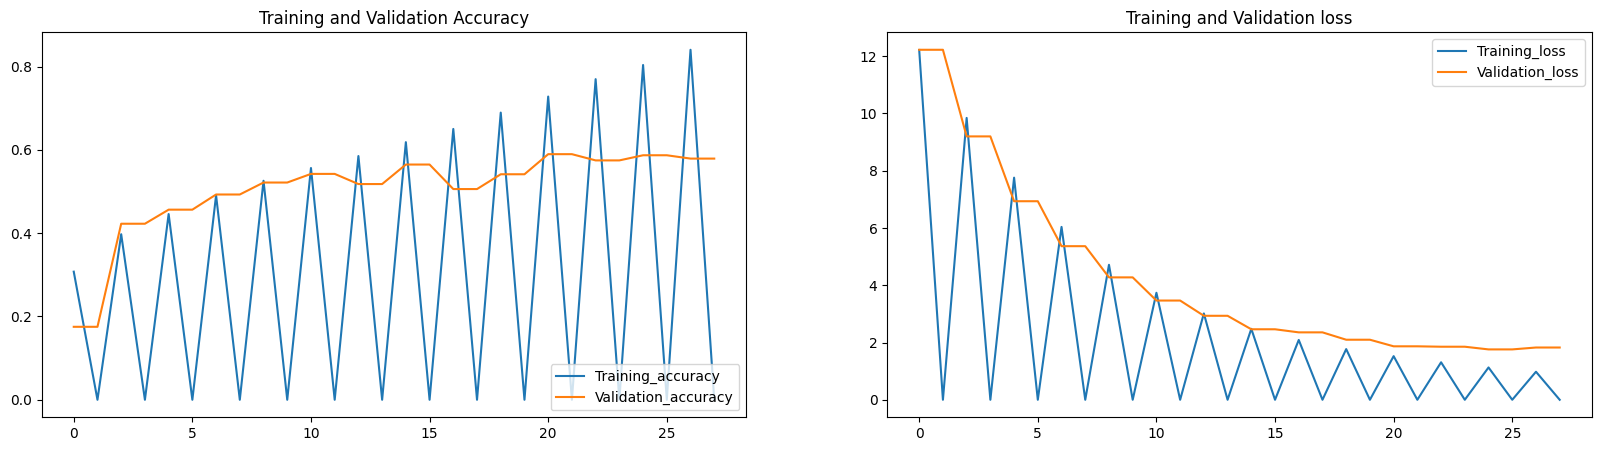

In [ ]:
plot_from_training(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.8940 - loss: 0.9075
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.5914 - loss: 1.7463
final train accuracy = 89.31 , validation accuracy = 59.63


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


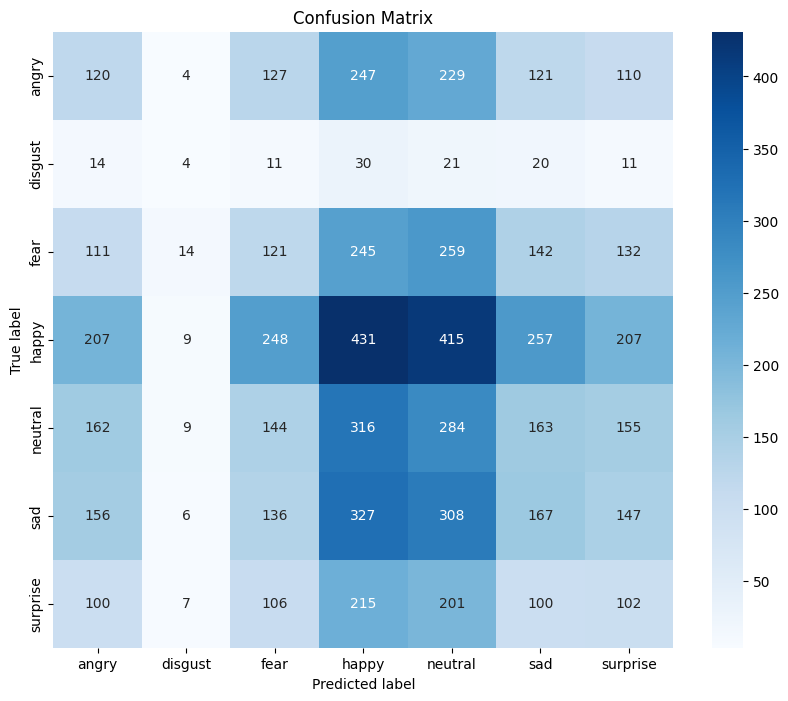

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
class_labels = list(test_generator.class_indices.keys())


cm = confusion_matrix(true_classes, predicted_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

After looking into these visualization we can say that our model is memorizing the training data and performing poor on validation data so it's a overfitting.

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.13      0.13       958
     disgust       0.08      0.04      0.05       111
        fear       0.14      0.12      0.13      1024
       happy       0.24      0.24      0.24      1774
     neutral       0.17      0.23      0.19      1233
         sad       0.17      0.13      0.15      1247
    surprise       0.12      0.12      0.12       831

    accuracy                           0.17      7178
   macro avg       0.15      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



# Making Predictions

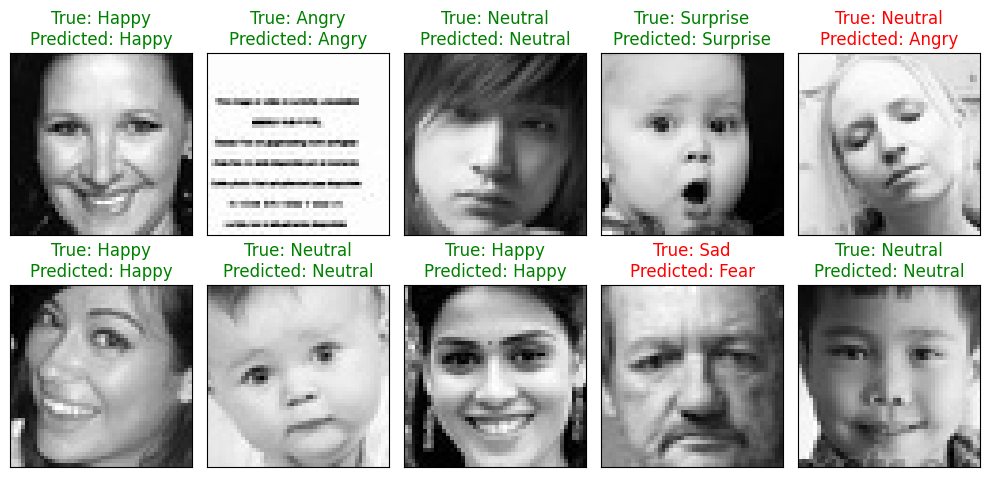

In [ ]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

batch_size = test_generator.batch_size

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
  Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
  Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

  Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

  ax.imshow(Random_Img.squeeze(), cmap='gray')
  color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
  ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

# Model 2: Image Augmentation

In [ ]:
train_dir='/content/train'
test_dir='/content/test'

In [ ]:
img_width,img_height=48,48
batch=64
epoch=10
num_classes=7

In [ ]:
data_generator=ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest',
                                  validation_split=0.2)

test_data_generator=ImageDataGenerator(rescale=1./255)

train_generator=data_generator.flow_from_directory(train_dir,
                               target_size=(img_width,img_height),
                               batch_size=batch,
                               class_mode='categorical',
                               color_mode='grayscale',
                               subset='training')
validation_generator=data_generator.flow_from_directory(train_dir,
                               target_size=(img_width,img_height),
                               batch_size=batch,
                               class_mode='categorical',
                               color_mode='grayscale',
                               subset='validation')
test_generator=data_generator.flow_from_directory(test_dir,
                               target_size=(img_width,img_height),
                               batch_size=batch,
                               class_mode='categorical',
                               color_mode='grayscale')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


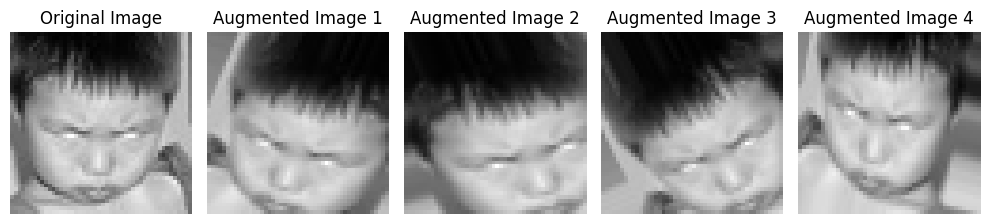

In [ ]:
image_path = '/content/train/angry/Training_10118481.jpg'

img=load_img(image_path,color_mode='grayscale',target_size=(img_width,img_height))
img_array=img_to_array(img)
img_array=img_array.reshape((1,)+img_array.shape)  #Keras expects input data with a batch size due to that we add one extra dimension to make 4D tensor

fig,axes=plt.subplots(nrows=1,ncols=5,figsize=(10,5))
axes[0].imshow(img_array[0,:,:,0],cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

for i,ax in enumerate(axes.flat[1:]):
  aug_iter=data_generator.flow(img_array,batch_size=1)
  aug_img=next(aug_iter)[0]

  ax.imshow(aug_img[:,:,0],cmap='gray')
  ax.set_title(f'Augmented Image {i+1}')
  ax.axis('off')

plt.tight_layout()
plt.show()

# Same CNN Model as above

In [ ]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),kernel_initializer='glorot_uniform',padding='same',input_shape=(img_width,img_height,1)))
model.add(Activation('relu'))
model.add(Conv2D(64,kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256,kernel_size=(3,3),kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes))
model.add(Activation('softmax'))


plot_model(model,to_file='/content/FER_2013_emotion_detection/Custom_CNN_with_augmentation/Architecture.png',show_shapes=True,
           show_layer_names=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])


cnn_path='/content/FER_2013_emotion_detection/Custom_CNN_with_augmentation/'
name='Custom_CNN_Models_Augemented.keras'
chk_path=os.path.join(cnn_path,name)


checkpoint=ModelCheckpoint(filepath=chk_path,
                           save_best_only=True,
                           verbose=1,
                           mode='min',
                           monitor='val_loss')

earlystop=EarlyStopping(monitor='val_loss',
                            min_delta=0.001,
                            patience=3,
                            verbose=1,
                            restore_best_weights=True)

reduce_lr=ReduceLROnPlateau(monitor='val_loss',
                            factor=0.2,
                            patience=6,
                            verbose=1,
                            min_delta=0.0001)

csvlogger=CSVLogger(os.path.join(cnn_path,'training.log'))

callback=[checkpoint,earlystop,reduce_lr,csvlogger]

train_steps_per_epoch=train_generator.samples//train_generator.batch_size+1
validation_steps_per_epoch=validation_generator.samples//validation_generator.batch_size+1
test_steps_per_epoch=test_generator.samples//test_generator.batch_size+1

history=model.fit(train_generator,
                  steps_per_epoch=train_steps_per_epoch,
                  epochs=30,
                  validation_data=validation_generator,
                  validation_batch_size=validation_steps_per_epoch,
                  callbacks=callback)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2131 - loss: 13.2530
Epoch 1: val_loss improved from inf to 11.80600, saving model to /content/FER_2013_emotion_detection/Custom_CNN_with_augmentation/Custom_CNN_Models_Augemented.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - accuracy: 0.2132 - loss: 13.2505 - val_accuracy: 0.1815 - val_loss: 11.8060 - learning_rate: 1.0000e-04
Epoch 2/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 11.80600
359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1829 - val_loss: 11.8136 - learning_rate: 1.0000e-04
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2489 - loss: 10.5514
Epoch 3: val_loss improved from 11.80600 to 9.08423, saving model to /content/FER_2013_emotion_detection/Custom_CNN_with_augmentation/Custom_CNN_Models_Augemented.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 70s 100ms/step - accuracy: 0.2489 - loss: 10.5498 - val_accuracy: 0.2350 - val_loss: 9.0842 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 9.08423 to 9.07412, saving model to /content/FER_2013_emotion_detection/Custom_CNN_with_augmentation/Custom_CNN_Models_Augemented.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2418 - val_loss: 9.0741 - learning_rate: 1.0000e-04
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - 

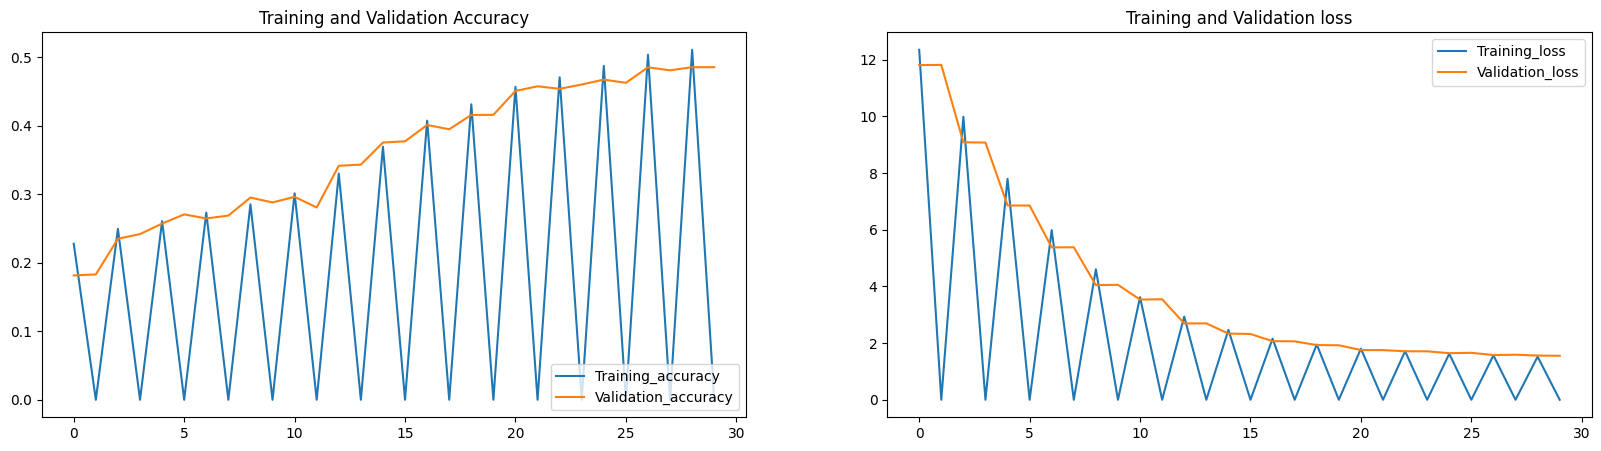

In [ ]:
plot_from_training(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.4987 - loss: 1.5255
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.4794 - loss: 1.5618
final train accuracy = 49.49 , validation accuracy = 47.98


113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step


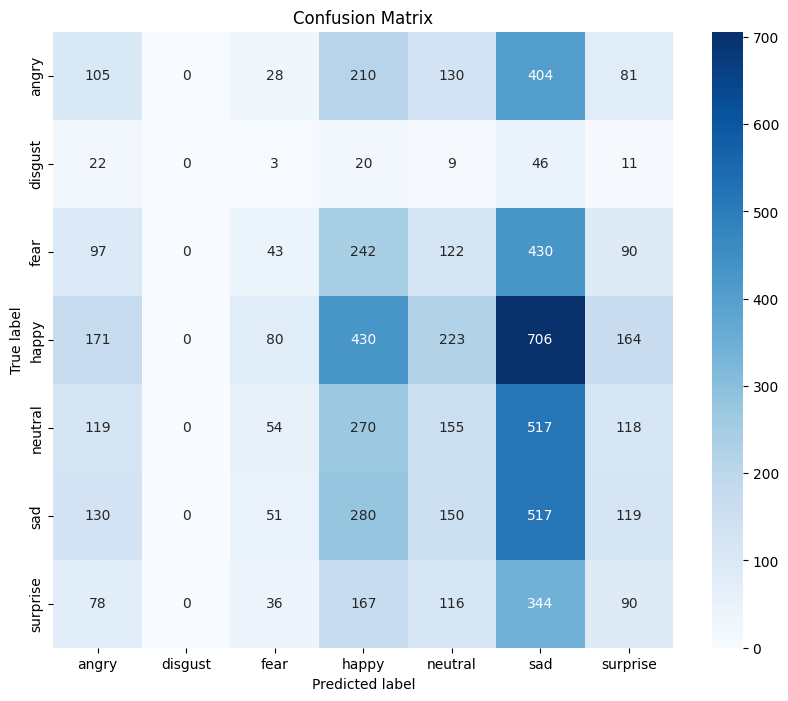

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
class_labels = list(test_generator.class_indices.keys())


cm = confusion_matrix(true_classes, predicted_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.15      0.11      0.12       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.04      0.07      1024
       happy       0.27      0.24      0.25      1774
     neutral       0.17      0.13      0.14      1233
         sad       0.17      0.41      0.25      1247
    surprise       0.13      0.11      0.12       831

    accuracy                           0.19      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.18      0.19      0.17      7178



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model 3: Transfer Learning VGGNET

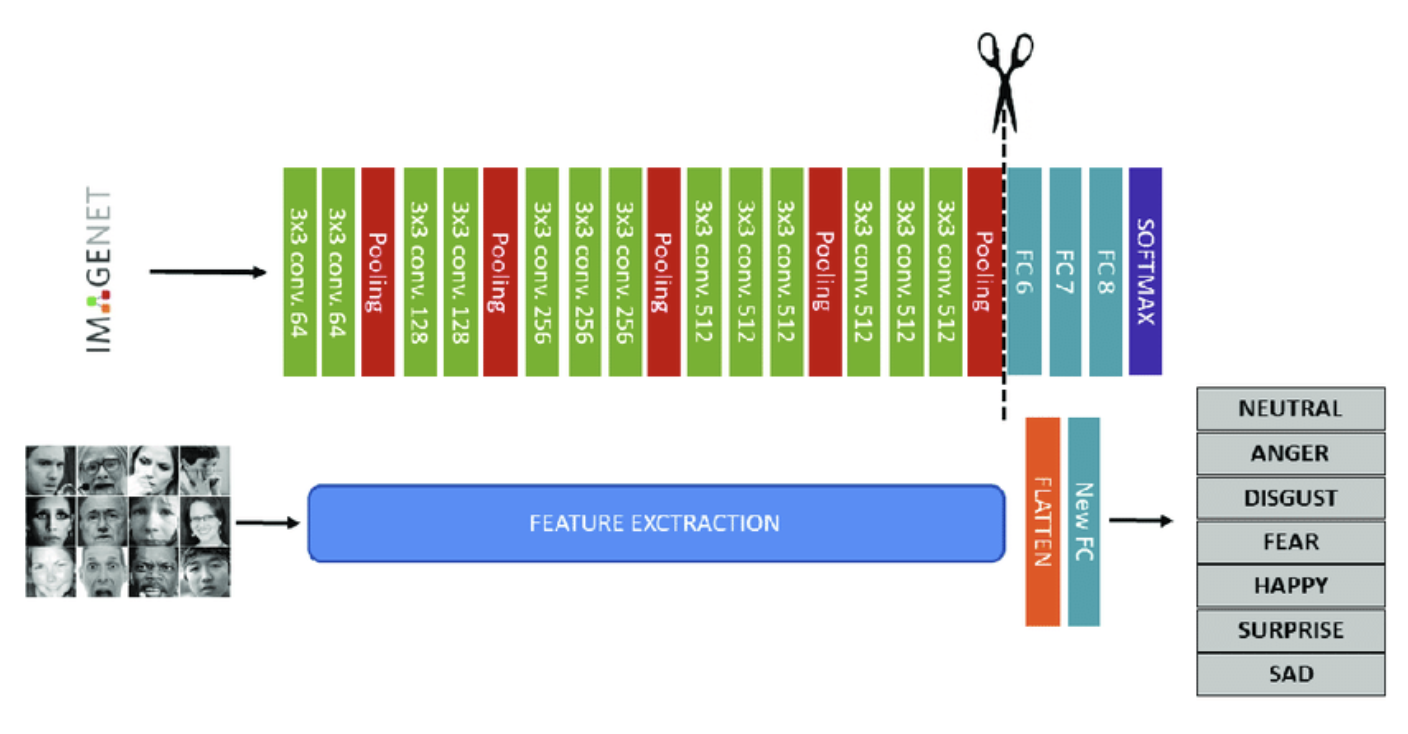

In [24]:
train_dir='/content/train'
test_dir='/content/test'

In [25]:
img_width,img_height=224,224
batch=64
epoch=10
num_classes=7

In [26]:
data_generator=ImageDataGenerator(rescale=1./255,
                                  rotation_range=10,
                                  zoom_range=0.2,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  fill_mode='nearest',
                                  validation_split=0.2)

train_generator=data_generator.flow_from_directory(train_dir,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch,
                                                   class_mode='categorical',
                                                   color_mode='rgb',
                                                   subset='training',
                                                   shuffle=True)

validation_generator=data_generator.flow_from_directory(train_dir,
                               target_size=(img_width,img_height),
                               batch_size=batch,
                               class_mode='categorical',
                               color_mode='rgb',
                               subset='validation')

test_generator=data_generator.flow_from_directory(test_dir,
                                                  target_size=(img_width,img_height),
                                                  batch_size=batch,
                                                  class_mode='categorical',
                                                  color_mode='rgb'
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [27]:
classes=np.array(train_generator.classes)

class_weights=compute_class_weight(class_weight='balanced',
                                    classes=np.unique(classes),
                                    y=classes)

class_weight_dict=dict(enumerate(class_weights))

print("Class Weights Dictionary:", class_weight_dict)

Class Weights Dictionary: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


In [28]:
classes=7

tf.keras.backend.clear_session()

vgg=VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
for layers in vgg.layers[:-3]:
  layers.trainable=False
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [30]:
x=Flatten()(vgg.output)

x=Dense(1024,activation='relu',kernel_initializer='he_normal')(x)
x=Dropout(0.5)(x)

x=Dense(512,activation='relu',kernel_initializer='he_normal')(x)
x=Dropout(0.5)(x)

output=Dense(7,activation='softmax',kernel_initializer='he_normal')(x)

model=Model(inputs=vgg.inputs,outputs=output)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,amsgrad=False),
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 40,934,215 (156.15 MB)

 Trainable params: 30,939,143 (118.02 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [31]:
cnn_path='/content/FER_2013_emotion_detection/Vgg16_transfer_learning/'
name='Vgg16_transfer_learning.keras'
chk_path=os.path.join(cnn_path,name)


checkpoint=ModelCheckpoint(filepath=chk_path,
                           save_best_only=True,
                           verbose=1,
                           mode='min',
                           monitor='val_loss')

earlystop=EarlyStopping(monitor='val_loss',
                            min_delta=0.001,
                            patience=3,
                            verbose=1,
                            restore_best_weights=True)

reduce_lr=ReduceLROnPlateau(monitor='val_loss',
                            factor=0.2,
                            patience=6,
                            verbose=1,
                            min_delta=0.0001)

csvlogger=CSVLogger(os.path.join(cnn_path,'training.log'))

callback=[checkpoint,earlystop,reduce_lr,csvlogger]

train_steps_per_epoch=train_generator.samples//train_generator.batch_size+1
validation_steps_per_epoch=validation_generator.samples//validation_generator.batch_size+1
test_steps_per_epoch=test_generator.samples//test_generator.batch_size+1

history=model.fit(train_generator,
                  steps_per_epoch=train_steps_per_epoch,
                  epochs=50,
                  validation_data=validation_generator,
                  validation_batch_size=validation_steps_per_epoch,
                  callbacks=callback)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.2782 - loss: 1.8273
Epoch 1: val_loss improved from inf to 1.42582, saving model to /content/FER_2013_emotion_detection/Vgg16_transfer_learning/Vgg16_transfer_learning.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 462s 1s/step - accuracy: 0.2784 - loss: 1.8268 - val_accuracy: 0.4583 - val_loss: 1.4258 - learning_rate: 1.0000e-04
Epoch 2/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 1.42582
359/359 ━━━━━━━━━━━━━━━━━━━━ 74s 206ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4524 - val_loss: 1.4325 - learning_rate: 1.0000e-04
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.4569 - loss: 1.4163
Epoch 3: val_loss improved from 1.42582 to 1.30695, saving model to /content/FER_2013_emotion_detection/Vgg16_transfer_learning/Vgg16_transfer_learning.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - accuracy: 0.4569 - loss: 1.4163 - val_accuracy: 0.5022 - val_loss: 1.3069 - learning_rate: 1.0000e-04
Epoch 4/50

Epoch 4: val_loss improved from 1.30695 to 1.30272, saving model to /content/FER_2013_emotion_detection/Vgg16_transfer_learning/Vgg16_transfer_learning.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 80s 222ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5044 - val_loss: 1.3027 - learning_rate: 1.0000e-04
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.5032 - los

In [35]:
model.save("Vgg16net_test.keras")

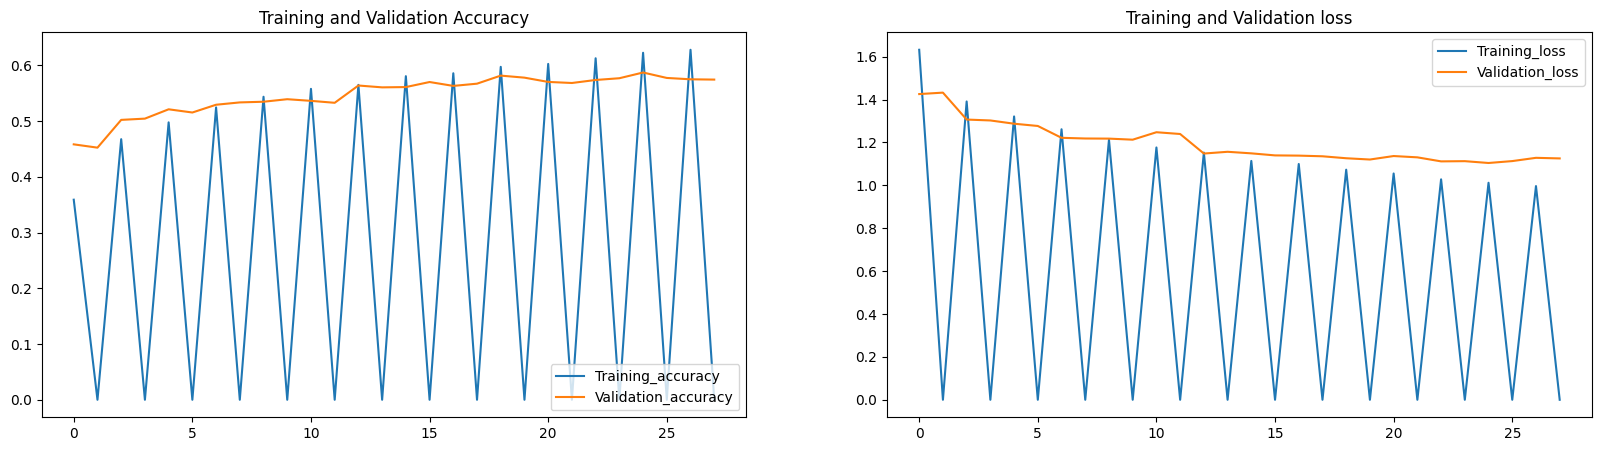

In [32]:
plot_from_training(history)

In [33]:
train_loss,train_acc=model.evaluate(train_generator)
test_loss,test_acc=model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 294s 819ms/step - accuracy: 0.6453 - loss: 0.9390
113/113 ━━━━━━━━━━━━━━━━━━━━ 100s 885ms/step - accuracy: 0.5913 - loss: 1.0759
final train accuracy = 64.57 , validation accuracy = 59.31


113/113 ━━━━━━━━━━━━━━━━━━━━ 85s 747ms/step


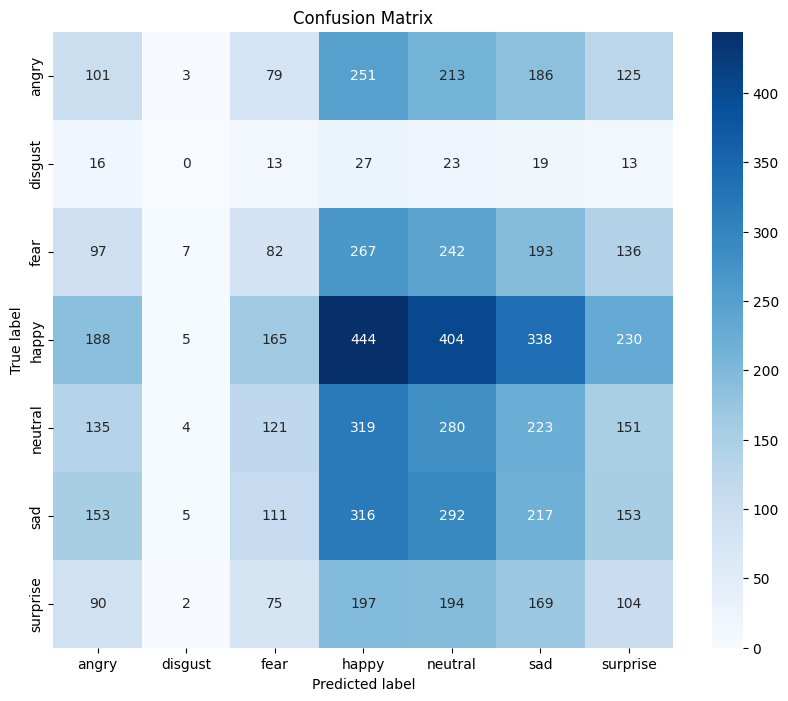

In [36]:
true_classes=test_generator.classes
predicted_classes=np.argmax(model.predict(test_generator,steps=int(np.ceil(test_generator.samples/test_generator.batch_size))),axis=1)
class_labels=list(test_generator.class_indices.keys())

cm=confusion_matrix(true_classes,predicted_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=class_labels,yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [38]:
report=classification_report(true_classes,predicted_classes,target_names=class_labels,zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.13      0.11      0.12       958
     disgust       0.00      0.00      0.00       111
        fear       0.13      0.08      0.10      1024
       happy       0.24      0.25      0.25      1774
     neutral       0.17      0.23      0.19      1233
         sad       0.16      0.17      0.17      1247
    surprise       0.11      0.13      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.17      0.17      7178



# Model 4 : Transfer Leanring - ResNet50